In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os,sys
import pylab as plt
%matplotlib inline
from pylab import get_cmap
import glob


In [2]:
src_dir = '../src'
sys.path.append(src_dir)
from jsd import jsdalpha

In [3]:
src_meta = '../../gutenberg/src/'
sys.path.append(src_meta)
from metaquery import meta_query


In [4]:
# Load meta data

In [5]:
meta=meta_query(path=src_meta+'../metadata/metadata.csv')

# Selection of authors

- get the authors of the 100 most downloaded books
- filter some authors (e.g. 'Anonymous')
- get the 20 authors with the most books

In [6]:
## get the authors from the n most downloaded books

meta.reset()
meta.filter_lang('en',how='only')
meta.filter_downloads(n=100)
list_authors_preselect = list(set(list(meta.get_df()['author'].dropna())))

In [7]:
# list_authors_preselect

In [8]:
## get number of books from all authors
list_ignore = ['Anonymous']
list_authors = []
list_n = []
Smax = -1 # maximum number of authors to consider
nmin=0 # minimum number of books
S = 0
for author in list_authors_preselect:
    meta.reset()
    meta.filter_lang('en',how='only')
    meta.filter_author(author)
    list_pg_tmp = meta.get_ids()
    n = len(list_pg_tmp)
    if author not in list_ignore:
        list_authors += [author]
        list_n += [n]
        print(author,n)


Kafka, Franz 3
Doyle, Arthur Conan 106
Swift, Jonathan 26
Thompson, Silvanus P. (Silvanus Phillips) 3
Augustine, Saint, Bishop of Hippo 5
Poe, Edgar Allan 29
Stowe, Harriet Beecher 30
Twain, Mark 201
Stevenson, Robert Louis 89
Du Bois, W. E. B. (William Edward Burghardt) 8
Gilman, Charlotte Perkins 8
Tolstoy, Leo, graf 47
Blake, William 7
Thoreau, Henry David 14
Voltaire 20
Nietzsche, Friedrich Wilhelm 27
Hugo, Victor 18
Whitman, Walt 11
Conrad, Joseph 68
Hobbes, Thomas 1
Montaigne, Michel de 22
Christie, Agatha 2
James, Henry 80
Collins, Wilkie 38
Austen, Jane 23
Carroll, Lewis 27
Vatsyayana 1
Barrie, J. M. (James Matthew) 30
Ibsen, Henrik 18
Marx, Karl 6
Homer 40
Dumas, Alexandre 60
Cleland, John 2
Shakespeare, William 193
Shelley, Mary Wollstonecraft 11
Wilde, Oscar 41
Brontë, Emily 1
Malory, Thomas, Sir 7
Marcus Aurelius, Emperor of Rome 3
Montgomery, L. M. (Lucy Maud) 25
Cervantes Saavedra, Miguel de 51
Franklin, Benjamin 14
Defoe, Daniel 61
Brontë, Charlotte 9
Hesse, Hermann 1
Sp

In [9]:
## select 20 authors with the most books
list_authors_sel = []
Smax = 20
S=0

indsort = np.argsort(list_n)[::-1]
for i in indsort:
    print(list_n[i],list_authors[i])
    list_authors_sel += [list_authors[i]]
    S +=1
    if S==Smax:
        break

201 Twain, Mark
193 Shakespeare, William
144 Dickens, Charles
106 Doyle, Arthur Conan
92 Baum, L. Frank (Lyman Frank)
89 Stevenson, Robert Louis
80 James, Henry
79 Wells, H. G. (Herbert George)
68 Conrad, Joseph
61 Defoe, Daniel
60 Dumas, Alexandre
54 Wharton, Edith
51 Cervantes Saavedra, Miguel de
47 Tolstoy, Leo, graf
46 Shaw, Bernard
46 Alcott, Louisa May
41 Wilde, Oscar
40 Homer
38 Collins, Wilkie
37 Dante Alighieri


In [10]:
## get book ids
list_books = []

lang = 'en'
for author in list_authors_sel:
    meta.reset()
    meta.filter_lang(lang,how='any')
    meta.filter_author(author)
    books_tmp = meta.get_ids()
    list_books += [books_tmp]

In [14]:
## calculate divergence
alpha = 1.0
Npair = 1000
weights = False ## standard 1/2,1.2
normalized = True ## 0<=divergence <=1

path_read = '../../gutenberg/data/counts/'

Na = len(list_authors_sel)

arr_jsd_1 = np.zeros((Na,Npair))
arr_jsd_2 = np.zeros((Na,Npair))

for i_s,s in enumerate(list_authors_sel):
    books_a=list_books[i_s]
    books_na=[ h  for i_s2,s2 in enumerate(list_authors_sel) for h in list_books[i_s2] if i_s!=i_s2]
    for i_Npair in range(Npair):
        ## 1st book from the author
        book_sel = True
        while book_sel== True:
            pg1, = np.random.choice(books_a,replace=False,size=1)
            fname_read = '%s_counts.txt'%(pg1)
            filename1 = os.path.join(path_read,fname_read)            
            if os.path.isfile(filename1):
                book_sel = False
                
        ## 2nd book: from the author - IN
        book_sel = True
        while book_sel== True:
            pg2_in, = np.random.choice(books_a,replace=False,size=1)
            fname_read = '%s_counts.txt'%(pg2_in)
            filename2_in = os.path.join(path_read,fname_read)            
            if os.path.isfile(filename2_in) and pg1!=pg2_in:
                book_sel = False 
        ## 2nd book: NOT from the author - OUT
        book_sel = True
        while book_sel== True:
            pg2_out, = np.random.choice(books_na,replace=False,size=1)
            fname_read = '%s_counts.txt'%(pg2_out)
            filename2_out = os.path.join(path_read,fname_read)            
            if os.path.isfile(filename2_out) and pg1!=pg2_out:
                book_sel = False        

        jsd_1 = jsdalpha(filename1,filename2_in,alpha=alpha,weights=weights,normalized=normalized)
        jsd_2 = jsdalpha(filename1,filename2_out,alpha=alpha,weights=weights,normalized=normalized)

        arr_jsd_1[i_s,i_Npair] = jsd_1
        arr_jsd_2[i_s,i_Npair] = jsd_2

# Plot

In [126]:
###########
## Setup ##
###########
# number of pt for column in latex-document
fig_width_pt = 510  # single-column:510, double-column: 246; Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.1/72.27 # Convert pt to inches
width_vs_height = (np.sqrt(5)-1.0)/2.0 # Ratio of height/width [(np.sqrt(5)-1.0)/2.0]
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = width_vs_height*fig_width  # height in inches
fig_size = [fig_width,fig_height]

# here you can set the parameters of the plot (fontsizes,...) in pt
params = {'backend': 'ps',
          'axes.titlesize':16,
          'axes.labelsize': 14,
          'text.fontsize': 12,
          'legend.fontsize': 12,
#           'figtext.fontsize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          
          'text.usetex': True,
          'ps.usedistiller' : 'xpdf',
          'figure.figsize': fig_size,
          'text.latex.unicode':True,
          'text.latex.preamble': [r'\usepackage{bm}'],
          
          'xtick.direction':'out',
          'ytick.direction':'out',
          
          'axes.spines.right' : False,
          'axes.spines.top' : False
         }
plt.rcParams.update(params)

/home/martin/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


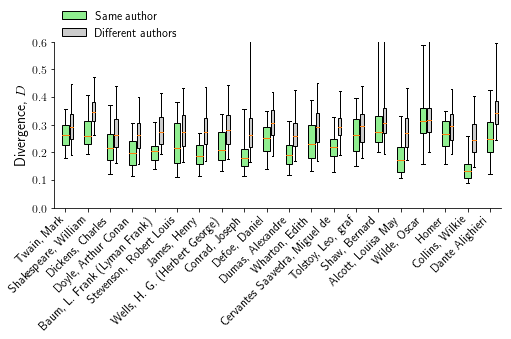

In [127]:

# f=plt.figure(figsize = (10,20))
f=plt.figure()
ax=f.add_subplot(1,1,1)
h=+0.275

## across distances: large box
x = np.arange(Na)+h
bp1 =ax.boxplot(arr_jsd_2.T,positions=x,
              vert=True,whis=[2.5,97.5],sym='',widths=0.15,patch_artist=True)
color = str(0.8)
for patch in bp1['boxes']:
    patch.set_facecolor(color)

## within distance
x = np.arange(Na)
bp2 =ax.boxplot(arr_jsd_1.T,positions=x,
              vert=True,whis=[5,95],sym='',widths=0.3,patch_artist=True)
color = 'lightgreen'
for patch in bp2['boxes']:
    patch.set_facecolor(color)

## legend    
ax.legend([bp2["boxes"][0], bp1["boxes"][0]], ['Same author', 'Different authors'],
          bbox_to_anchor=(0.3,1.25),frameon=False)# bbox_to_anchor=(0.3,1.))


import re
list_labels = [h[:30] for h in list_authors_sel]
ax.set_xticklabels(list_labels,rotation=45, ha='right')

ax.set_ylim(0.,0.6)
ax.set_ylabel(r'Divergence, $D$')
# ax.set_ylabel('Author')

plt.subplots_adjust(left=0.1,bottom=0.4)

path_save = os.path.join(os.pardir,'figures')
fname_save = 'divergence_authors.pdf'
filename = os.path.join(path_save,fname_save)
plt.savefig(filename)